In [1]:
pip install pyspark tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

2024-11-15 23:45:30.302254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-15 23:45:30.341325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-15 23:45:30.356018: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 23:45:30.435027: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-15 23:45:31.594167: W tensorflow/compiler/tf2

In [28]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("ReadSnappyParquet") \
    .getOrCreate()

# Path to the .snappy.parquet file or directory
parquet_path = "/home/yasminehabchi/delta_lake/delta_lake_table/"

# Read the .snappy.parquet files
df = spark.read.parquet(parquet_path)

# Display the content
df.show()

# Print schema
df.printSchema()



+-------------------+--------------+--------------------+--------+---------+----------------+----------+----------+----------+------------+-----------------+------------+--------+
|           datetime|          name|             country|latitude|longitude|        timezone|max_temp_c|min_temp_c|avg_temp_c|max_wind_mph|avg_visibility_km|avg_humidity|uv_index|
+-------------------+--------------+--------------------+--------+---------+----------------+----------+----------+----------+------------+-----------------+------------+--------+
|2024-11-16 00:03:00|         Tunis|             Tunisia| 36.8028|  10.1797|    Africa/Tunis|      NULL|      NULL|      NULL|        NULL|             NULL|        NULL|    NULL|
|2024-11-15 18:10:00|Virginia Beach|United States of ...| 36.8528| -75.9783|America/New_York|      NULL|      NULL|      NULL|        NULL|             NULL|        NULL|    NULL|
|2024-11-15 18:10:00|Virginia Beach|United States of ...| 36.8528| -75.9783|America/New_York|      N

In [10]:
feature_columns = ['relative_humidity_2m', 'dew_point_2m',
                   'apparent_temperature', 'precipitation', 'rain', 'snowfall',
                   'weather_code', 'pressure_msl', 'surface_pressure', 'cloud_cover',
                   'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
                   'et0_fao_evapotranspiration', 'vapour_pressure_deficit',
                   'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m',
                   'wind_direction_100m', 'wind_gusts_10m', 'soil_temperature_0_to_7cm',
                   'soil_temperature_7_to_28cm', 'soil_temperature_28_to_100cm',
                   'soil_temperature_100_to_255cm', 'soil_moisture_0_to_7cm',
                   'soil_moisture_7_to_28cm', 'soil_moisture_28_to_100cm',
                   'soil_moisture_100_to_255cm', 'is_day', 'sunshine_duration']


24/11/16 00:09:09 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


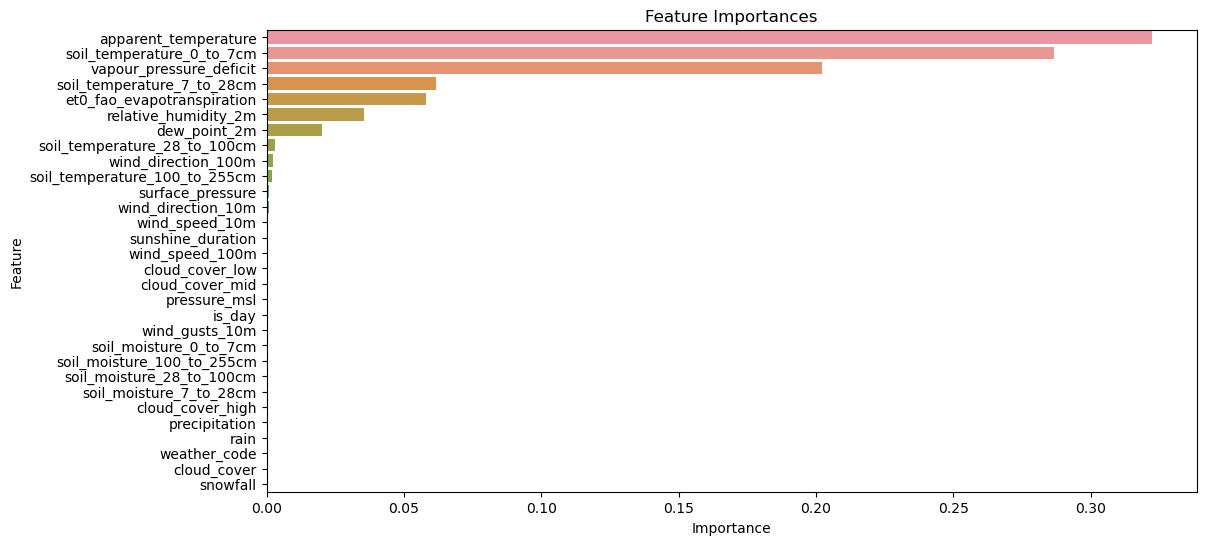

In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'temperature_2m' is the target variable
target_variable = 'temperature_2m'

# Create a SparkSession
spark = SparkSession.builder.appName("WeatherPrediction").getOrCreate()

# Create a Vector Assembler
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
assembled_data = vector_assembler.transform(weather_data).select('features', col(target_variable).alias('label'))

# Split the data into training and testing sets
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=42)

# Train a RandomForestRegressor
rf = RandomForestRegressor(featuresCol='features', labelCol='label')
rf_model = rf.fit(train_data)

# Get feature importances
feature_importances = rf_model.featureImportances.toArray()

# Create a Pandas DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualize feature importances using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()

In [12]:
# Select the top 4 features based on importance
selected_features = feature_importance_df['Feature'].head(4).tolist()
print("Selected Features:", selected_features)

Selected Features: ['apparent_temperature', 'soil_temperature_0_to_7cm', 'vapour_pressure_deficit', 'soil_temperature_7_to_28cm']


In [13]:
# Create a new DataFrame with the final selected features and the target variable
final_data = vector_assembler.transform(weather_data).select(['time'] +  [ 'temperature_2m' ]) # selected_features +
final_data.show(2)

+-------------------+--------------+
|               time|temperature_2m|
+-------------------+--------------+
|2018-01-01 00:00:00|          16.4|
|2018-01-01 01:00:00|          15.4|
+-------------------+--------------+
only showing top 2 rows



In [14]:
# Sort the data based on 'time'
data = final_data.orderBy('time')
data.show()

+-------------------+--------------+
|               time|temperature_2m|
+-------------------+--------------+
|2018-01-01 00:00:00|          16.4|
|2018-01-01 01:00:00|          15.4|
|2018-01-01 02:00:00|          14.8|
|2018-01-01 03:00:00|          14.5|
|2018-01-01 04:00:00|          13.7|
|2018-01-01 05:00:00|          13.9|
|2018-01-01 06:00:00|          15.9|
|2018-01-01 07:00:00|          15.5|
|2018-01-01 08:00:00|          14.1|
|2018-01-01 09:00:00|          16.6|
|2018-01-01 10:00:00|          19.8|
|2018-01-01 11:00:00|          24.0|
|2018-01-01 12:00:00|          25.6|
|2018-01-01 13:00:00|          26.9|
|2018-01-01 14:00:00|          26.0|
|2018-01-01 15:00:00|          25.2|
|2018-01-01 16:00:00|          26.1|
|2018-01-01 17:00:00|          23.8|
|2018-01-01 18:00:00|          18.1|
|2018-01-01 19:00:00|          17.0|
+-------------------+--------------+
only showing top 20 rows



In [15]:
# Split the data into training and testing sets based on the specified time
final_selected_features = ['time']

training_data = data.filter(col('time') < '2023-01-01 12:00:00')
testing_data = data.filter(col('time') >= '2023-01-01 12:00:00')

# Separate features and target variable
X_train = training_data.select(final_selected_features)
y_train = training_data.select('temperature_2m')

X_test = training_data.select(final_selected_features)
y_test = training_data.select('temperature_2m')
y_test.show()

+--------------+
|temperature_2m|
+--------------+
|          16.4|
|          15.4|
|          14.8|
|          14.5|
|          13.7|
|          13.9|
|          15.9|
|          15.5|
|          14.1|
|          16.6|
|          19.8|
|          24.0|
|          25.6|
|          26.9|
|          26.0|
|          25.2|
|          26.1|
|          23.8|
|          18.1|
|          17.0|
+--------------+
only showing top 20 rows



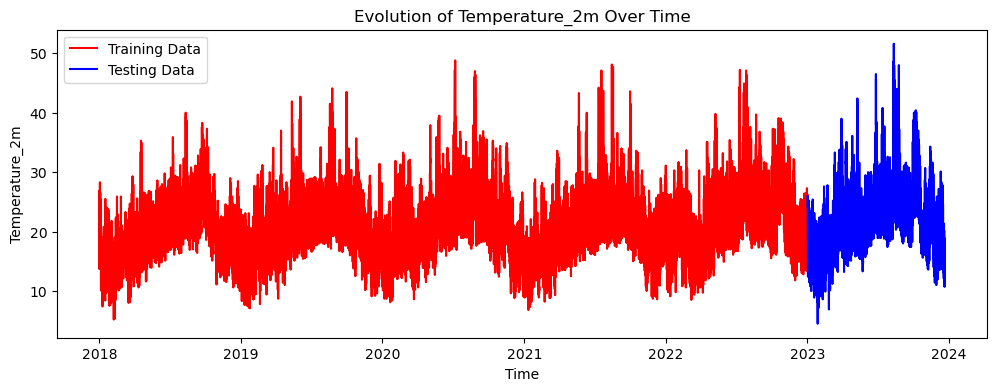

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(training_data.select('time').rdd.flatMap(lambda x: x).collect(), training_data.select('temperature_2m').rdd.flatMap(lambda x: x).collect(), color='red', label='Training Data')
plt.plot(testing_data.select('time').rdd.flatMap(lambda x: x).collect(), testing_data.select('temperature_2m').rdd.flatMap(lambda x: x).collect(), color='blue', label='Testing Data')
plt.xlabel('Time')
plt.ylabel('Temperature_2m')
plt.title('Evolution of Temperature_2m Over Time')
plt.legend()
plt.show()

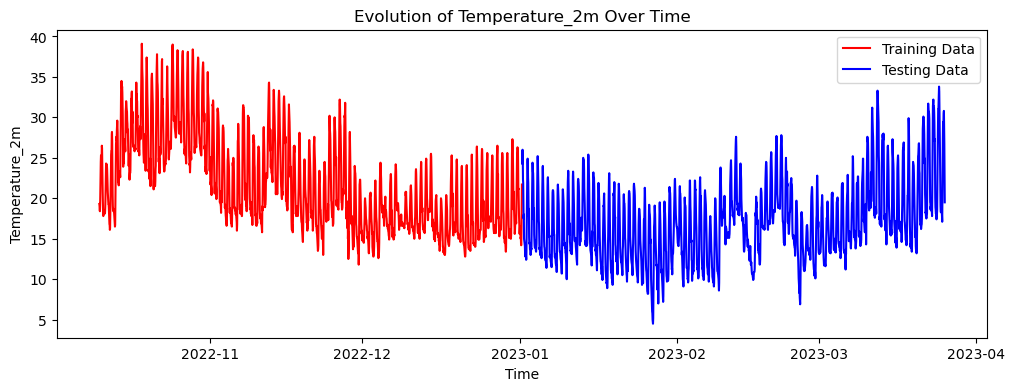

In [17]:
num = 2000
plt.figure(figsize=(12, 4))
plt.plot(training_data.select('time').rdd.flatMap(lambda x: x).collect()[-num:], training_data.select('temperature_2m').rdd.flatMap(lambda x: x).collect()[-num:], color='red', label='Training Data')
plt.plot(testing_data.select('time').rdd.flatMap(lambda x: x).collect()[:num], testing_data.select('temperature_2m').rdd.flatMap(lambda x: x).collect()[:num], color='blue', label='Testing Data')
plt.xlabel('Time')
plt.ylabel('Temperature_2m')
plt.title('Evolution of Temperature_2m Over Time')
plt.legend()
plt.show()

In [18]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, weekofyear, month, quarter, dayofweek, dayofmonth, dayofyear

# Create new columns based on 'time'
X_test = (X_test
    .withColumn('hour', hour('time'))
    .withColumn('week', weekofyear('time'))
    .withColumn('month', month('time'))
    .withColumn('quarter', quarter('time'))
    .withColumn('day_of_week', dayofweek('time'))
    .withColumn('day_of_month', dayofmonth('time'))
    .withColumn('day_of_year', dayofyear('time'))
)

# Create new columns based on 'time'
X_train= (X_train
    .withColumn('hour', hour('time'))
    .withColumn('week', weekofyear('time'))
    .withColumn('month', month('time'))
    .withColumn('quarter', quarter('time'))
    .withColumn('day_of_week', dayofweek('time'))
    .withColumn('day_of_month', dayofmonth('time'))
    .withColumn('day_of_year', dayofyear('time'))
)
X_test.show(2000)

+-------------------+----+----+-----+-------+-----------+------------+-----------+
|               time|hour|week|month|quarter|day_of_week|day_of_month|day_of_year|
+-------------------+----+----+-----+-------+-----------+------------+-----------+
|2018-01-01 00:00:00|   0|   1|    1|      1|          2|           1|          1|
|2018-01-01 01:00:00|   1|   1|    1|      1|          2|           1|          1|
|2018-01-01 02:00:00|   2|   1|    1|      1|          2|           1|          1|
|2018-01-01 03:00:00|   3|   1|    1|      1|          2|           1|          1|
|2018-01-01 04:00:00|   4|   1|    1|      1|          2|           1|          1|
|2018-01-01 05:00:00|   5|   1|    1|      1|          2|           1|          1|
|2018-01-01 06:00:00|   6|   1|    1|      1|          2|           1|          1|
|2018-01-01 07:00:00|   7|   1|    1|      1|          2|           1|          1|
|2018-01-01 08:00:00|   8|   1|    1|      1|          2|           1|          1|
|201

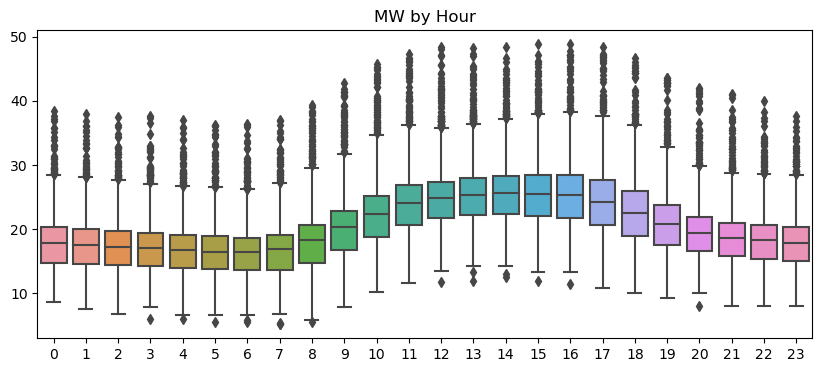

In [19]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot( x=X_train.select('hour').rdd.flatMap(lambda x: x).collect(), y=y_train.select('temperature_2m').rdd.flatMap(lambda x: x).collect())
ax.set_title('MW by Hour')
plt.show()

In [20]:
y_train

DataFrame[temperature_2m: double]

In [21]:

X_train_pd = X_train.withColumn("time", col("time").cast("string")).toPandas()
y_train_pd = y_train.toPandas()
X_test_pd = X_test.withColumn("time", col("time").cast("string")).toPandas()
y_test_pd = y_test.toPandas()

In [22]:
# Combine X_train and y_train into a single Pandas DataFrame
train_data = pd.concat([X_train_pd, y_train_pd], axis=1)

# Combine X_test and y_test into a single Pandas DataFrame
test_data = pd.concat([X_test_pd, y_test_pd], axis=1)

In [23]:
# Normalize the data
feature_columns = [ 'hour', 'week', 'month', 'quarter', 'day_of_week',
       'day_of_month', 'day_of_year']

scaler = MinMaxScaler()
train_data[feature_columns] = scaler.fit_transform(train_data[feature_columns])
test_data[feature_columns] = scaler.transform(test_data[feature_columns])
spark.createDataFrame(train_data).show()

+-------------------+--------------------+----+-----+-------+-------------------+------------+-----------+--------------+
|               time|                hour|week|month|quarter|        day_of_week|day_of_month|day_of_year|temperature_2m|
+-------------------+--------------------+----+-----+-------+-------------------+------------+-----------+--------------+
|2018-01-01 00:00:00|                 0.0| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|          16.4|
|2018-01-01 01:00:00|0.043478260869565216| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|          15.4|
|2018-01-01 02:00:00| 0.08695652173913043| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|          14.8|
|2018-01-01 03:00:00| 0.13043478260869565| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|          14.5|
|2018-01-01 04:00:00| 0.17391304347826086| 0.0|  0.0|    0.0|0.16666666666666666|         0.0|        0.0|          13.7|
|2018-01-01 05:00:00| 0.

In [24]:
# Create sequences for LSTM
def create_sequences(data, sequence_length=24):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequence = data.iloc[i:i+sequence_length]
        sequences.append(sequence.values)
    return np.array(sequences)

# Create sequences for training and testing
sequence_length = 24  # You can adjust this based on your preference
X_train_seq = create_sequences(train_data[feature_columns])
y_train_seq = train_data['temperature_2m'].values[sequence_length-1:]

X_test_seq = create_sequences(test_data[feature_columns])
y_test_seq = test_data['temperature_2m'].values[sequence_length-1:]
X_train_seq

array([[[0.        , 0.        , 0.        , ..., 0.16666667,
         0.        , 0.        ],
        [0.04347826, 0.        , 0.        , ..., 0.16666667,
         0.        , 0.        ],
        [0.08695652, 0.        , 0.        , ..., 0.16666667,
         0.        , 0.        ],
        ...,
        [0.91304348, 0.        , 0.        , ..., 0.16666667,
         0.        , 0.        ],
        [0.95652174, 0.        , 0.        , ..., 0.16666667,
         0.        , 0.        ],
        [1.        , 0.        , 0.        , ..., 0.16666667,
         0.        , 0.        ]],

       [[0.04347826, 0.        , 0.        , ..., 0.16666667,
         0.        , 0.        ],
        [0.08695652, 0.        , 0.        , ..., 0.16666667,
         0.        , 0.        ],
        [0.13043478, 0.        , 0.        , ..., 0.16666667,
         0.        , 0.        ],
        ...,
        [0.95652174, 0.        , 0.        , ..., 0.16666667,
         0.        , 0.        ],
        [1. 

In [25]:
# Build the deep LSTM model with 10 hidden layers
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
for _ in range(8):  # Add 8 more LSTM layers
    model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu'))  # Last LSTM layer without return_sequences
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

I0000 00:00:1731712191.377312   23602 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731712191.491055   23602 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731712191.491282   23602 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731712191.493323   23602 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        11,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,451 (755.67 KB)

 Trainable params: 193,451 (755.67 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=15, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/15


I0000 00:00:1731712197.838290   29658 service.cc:146] XLA service 0xaa73f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731712197.838313   29658 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-11-16 00:09:58.027619: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-16 00:09:59.213748: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
2024-11-16 00:09:59.780510: W external/local_xla/xla/stream_executor/gpu/redzone_allocator_kernel_cuda.cc:136] NOT_FOUND: Couldn't find a suitable version of ptxas. The following locations were considered: ./cuda_sdk_lib/bin/ptxas, /home/yasminehabchi/anaconda3/bin/ptxas, /opt/apache-maven-3.6.3/bin/ptxas, /home/yasminehabchi/.local/bin/ptxas, /home/yasminehabchi/Downloads/apache-tomcat

NotFoundError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/yasminehabchi/anaconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/yasminehabchi/anaconda3/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/yasminehabchi/anaconda3/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/yasminehabchi/anaconda3/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once

  File "/home/yasminehabchi/anaconda3/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_23602/3299210463.py", line 2, in <module>

  File "/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Couldn't find a suitable version of ptxas. The following locations were considered: ./cuda_sdk_lib/bin/ptxas, /home/yasminehabchi/anaconda3/bin/ptxas, /opt/apache-maven-3.6.3/bin/ptxas, /home/yasminehabchi/.local/bin/ptxas, /home/yasminehabchi/Downloads/apache-tomcat-10.1.9/bin/ptxas, /usr/lib/jvm/jdk-21.0.4-oracle-x64/bin/ptxas, /home/yasminehabchi/anaconda3/bin/ptxas, /home/yasminehabchi/anaconda3/condabin/ptxas, /opt/maven/bin/ptxas, /opt/apache-maven-3.6.3/bin/ptxas, /home/yasminehabchi/.local/bin/ptxas, /opt/maven/bin/ptxas, /usr/local/sbin/ptxas, /usr/local/bin/ptxas, /usr/sbin/ptxas, /usr/bin/ptxas, /sbin/ptxas, /bin/ptxas, /usr/games/ptxas, /usr/local/games/ptxas, /snap/bin/ptxas, /snap/bin/ptxas, /home/yasminehabchi/Downloads/apache-activemq-5.18.1/bin/ptxas, /usr/local/cuda-12.3/bin/ptxas, /usr/local/cuda/bin/ptxas, /home/yasminehabchi/anaconda3/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc/bin/ptxas, /home/yasminehabchi/anaconda3/lib/python3.10/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc/bin/ptxas
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_15875]

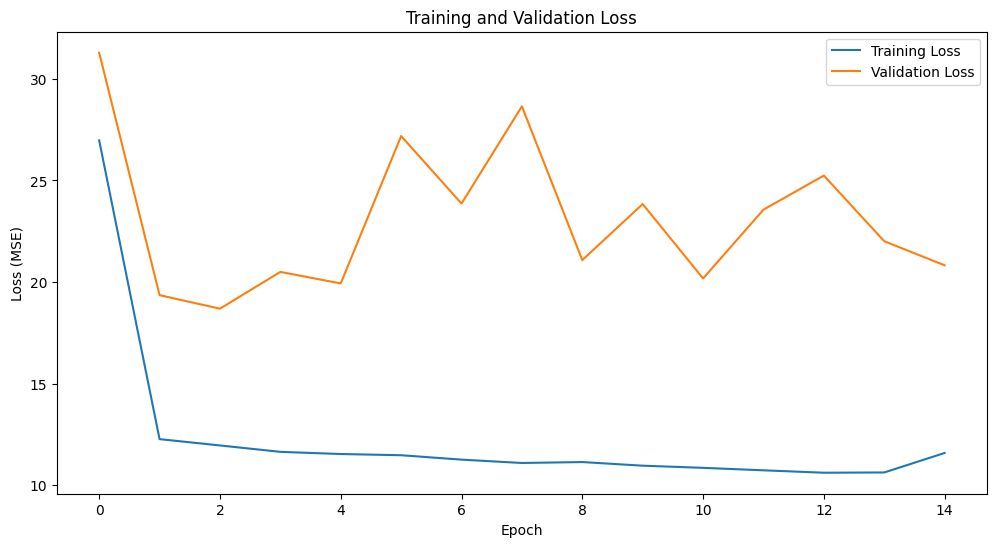

In [ ]:
# Plot the loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [ ]:
# Reshape predictions for compatibility with evaluation functions
y_pred = y_pred.flatten()

# Calculate metrics
mae = mean_absolute_error(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)
rmse = mean_squared_error(y_test_seq, y_pred, squared=False)
r2 = r2_score(y_test_seq, y_pred)

print("Mean Absolute Error: {}".format(mae))
print("Mean Squared Error: {}".format(mse))
print("Root Mean Squared Error: {}".format(rmse))
print("R-squared: {}".format(r2))

Mean Absolute Error: 2.4098195604946833
Mean Squared Error: 11.65433335971432
Root Mean Squared Error: 3.4138443666509346
R-squared: 0.6490038712783298


1370/1370 [==============================] - 79s 58ms/step
RMSE: 3.4138443666509346


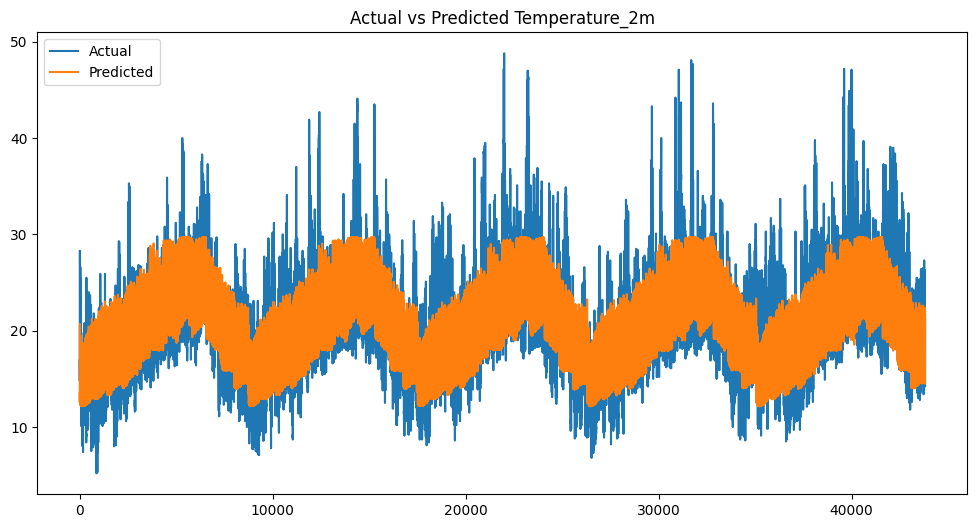

In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test_seq)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
print("RMSE:", rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Temperature_2m')
plt.legend()
plt.show()

In [ ]:
import os
from tensorflow.keras.models import save_model, load_model

# ... (previous code)

# Save the model to the 'models' folder
model_save_path = 'models/model_lstm'
os.makedirs('models', exist_ok=True)
save_model(model, model_save_path)



INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


In [ ]:

# Load the model from the 'models' folder
loaded_model = load_model(model_save_path)


1370/1370 [==============================] - 76s 54ms/step
RMSE (loaded model): 3.4138443666509346


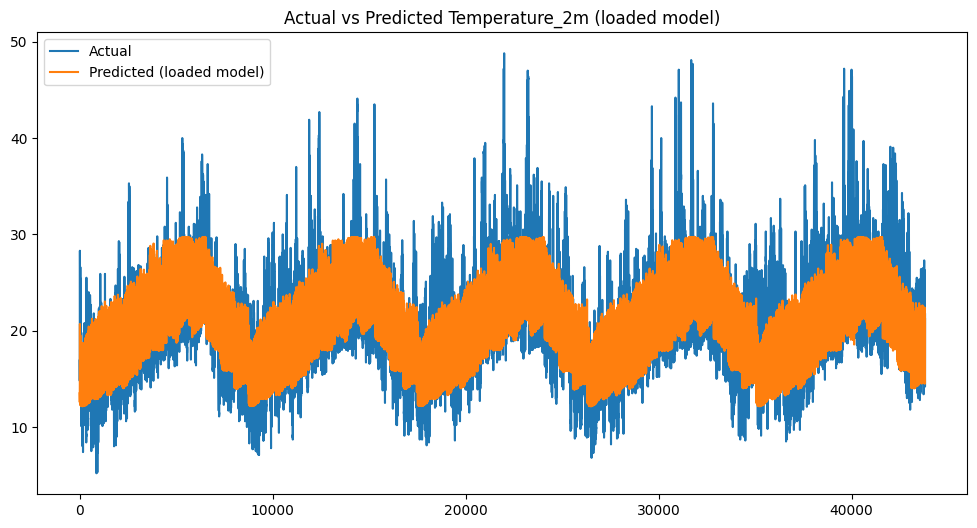

In [ ]:

# Make predictions on the test data using the loaded model
y_pred_loaded = loaded_model.predict(X_test_seq)

# Calculate RMSE (Root Mean Squared Error) using the loaded model
rmse_loaded = np.sqrt(mean_squared_error(y_test_seq, y_pred_loaded))
print("RMSE (loaded model):", rmse_loaded)

# Plot the actual vs predicted values using the loaded model
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred_loaded, label='Predicted (loaded model)')
plt.title('Actual vs Predicted Temperature_2m (loaded model)')
plt.legend()
plt.show()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, weekofyear, month, quarter, dayofweek, dayofmonth, dayofyear



X_test = (X_test
    .withColumn('hour', hour('time'))
    .withColumn('week', weekofyear('time'))
    .withColumn('month', month('time'))
    .withColumn('quarter', quarter('time'))
    .withColumn('day_of_week', dayofweek('time'))
    .withColumn('day_of_month', dayofmonth('time'))
    .withColumn('day_of_year', dayofyear('time'))
)


In [ ]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName('Elephas_App').setMaster('local[8]')
spark = SparkContext(conf=conf)
file_path = 'data/weather_data.csv'
sep = '|'
weather_data = spark.read.option("sep", sep).csv(file_path, header=True, inferSchema=True)


ConnectionRefusedError: [Errno 111] Connection refused